In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_prc = pd.read_pickle('./kospi_kosdaq_adjprc.pkl')
start = datetime(2003,1,1)
end = datetime(2015,1,1)
df_prc = df_prc.loc[start:end]

Dirichlet(1/2) without transaction cost

In [14]:
n_manager = 100
alpha = np.ones(len(df_prc.columns))/2
b = np.zeros(len(df_prc.columns))

init_nav = 1e7
tax_ratio = 0.003
fee_ratio = 0.00015

df_quantity = pd.DataFrame(np.zeros(df_prc.shape), index=df_prc.index, columns=df_prc.columns)
cash = pd.Series(init_nav, index=df_prc.index)
nav = pd.Series(index=df_prc.index.values)

for idx, date in enumerate(df_prc.index):
    
    assert cash[idx] > 0, "Cash should be always larger than 0. No short selling"
    if idx == 0 :
        nav[idx] = cash[idx]
        continue
    nav[idx] = cash[idx-1]+np.dot(df_quantity.iloc[idx-1], df_prc.iloc[idx-1])
    if idx == 1 : continue
        
    d_mu = np.random.dirichlet(alpha, n_manager)
    d_nav = (df_prc.diff().iloc[idx-1])/df_prc.iloc[idx-2]
    d_nav = np.dot(d_mu, d_nav)
    b = np.dot(np.transpose(d_nav), d_mu) / sum(d_nav)
    b = np.floor_divide((cash[idx-1]*b), df_prc.iloc[idx-1]*(1+fee_ratio))
    
    df_quantity.iloc[idx] = b
    cash[idx] = cash[idx-1] + np.dot((df_quantity.iloc[idx-1]-b).apply(lambda x : x*(1+fee_ratio) if x>0 else x*(1-fee_ratio-tax_ratio)),df_prc.iloc[idx-1])

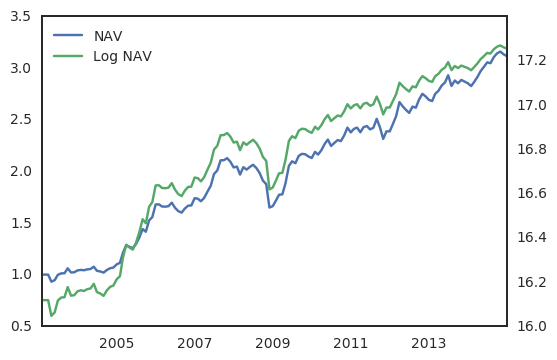

In [53]:
sns.set_style("white")

fig, ax = plt.subplots()
ax.plot(nav/nav[0], color=sns.color_palette()[0], label='NAV')
ax.plot(np.nan, color=sns.color_palette()[1], label = 'Log NAV')
ax2 = ax.twinx()
ax2.plot(np.log(nav), color=sns.color_palette()[1], label="Log NAV")

ax.legend(loc='upper left')

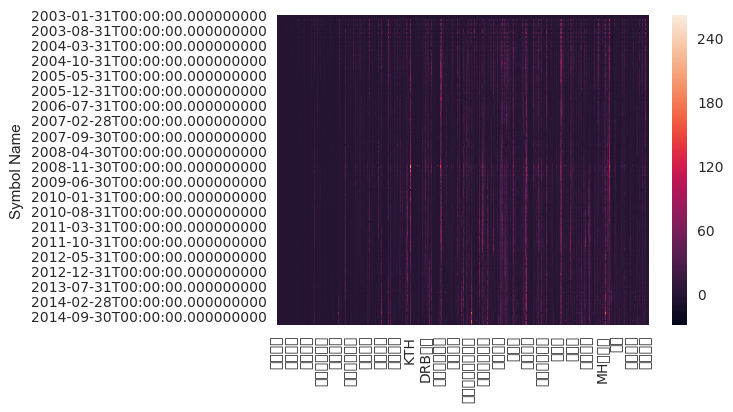

In [54]:
sns.heatmap(df_quantity)